In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
  
import time
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, PowerTransformer, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score,RandomizedSearchCV, StratifiedKFold
from scipy.stats import randint as sp_randint
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score
import scipy.stats as stats
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.metrics import recall_score, f1_score, confusion_matrix, classification_report, accuracy_score,precision_score

In [2]:
df=pd.read_csv('Diabetes_cleaned.csv')
df.head()

race  gender  age discharge_disposition_id admission_source_id  \
0        Caucasian       0    5            Not Available            Referral   
1        Caucasian       0   15       Discharged to home           Emergency   
2  AfricanAmerican       0   25       Discharged to home           Emergency   
3        Caucasian       1   35       Discharged to home           Emergency   
4        Caucasian       1   45       Discharged to home           Emergency   

   time_in_hospital  num_lab_procedures  num_procedures  num_medications  \
0                 1                  41               0                1   
1                 3                  59               0               18   
2                 2                  11               5               13   
3                 2                  44               1               16   
4                 1                  51               0                8   

                                        diag_1  ... glipizide glyburide  \
0                                     Diabetes  ...        -2        -2   
1  Endocrine, Nutritional, Metabolic, Immunity  ...        -2        -2   
2                        Pregnancy, Childbirth  ...         0        -2   
3                     Infectious and Parasitic  ...        -2        -2   
4                                    Neoplasms  ...         0        -2   

   pioglitazone rosiglitazone insulin  diabetesMed  readmitted  \
0            -2            -2      -2            0           0   
1            -2            -2       1            1           0   
2            -2            -2      -2            1           0   
3            -2            -2       1            1           0   
4            -2            -2       0            1           0   

   preceding_year_visits  number_changes  insulin_treatment  
0                      0             0.0             no_med  
1                      0             1.0       insulin_only  
2                      3             0.0         other_meds  
3                      0             1.0       insulin_only  
4                      0             0.0      insulin_combo  

[5 rows x 28 columns]

### Baseline Model

In [3]:
X = df.drop(labels='readmitted', axis=1)
y = df['readmitted']

In [4]:
X_dum = pd.get_dummies(X, drop_first = True)
X_train, X_test, y_train, y_test = train_test_split(X_dum, y, test_size = 0.3, random_state = 0, stratify = y)
X_train.shape, X_test.shape

((67949, 95), (29121, 95))

In [5]:
X_train.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in X_train.columns]
X_test.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in X_test.columns]

In [6]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state = 0, n_jobs = -1)
rf.fit(X_train, y_train)
y_train_pred = rf.predict(X_train)
y_train_prob = rf.predict_proba(X_train)[:, 1]
y_test_pred = rf.predict(X_test)
y_test_prob = rf.predict_proba(X_test)[:, 1]

print("Train Accuracy Score:", accuracy_score(y_train, y_train_pred))
print("Train Confusion Matrix:\n", confusion_matrix(y_train, y_train_pred), '\n')
print("Train F1 Score:", f1_score(y_train, y_train_pred))
print("Train Precision Score:", precision_score(y_train, y_train_pred))
print("Train Recall Score:", recall_score(y_train, y_train_pred))
print("Train ROC_AUC Score:", roc_auc_score(y_train, y_train_prob))
print()
print("Test Accuracy Score:", accuracy_score(y_test, y_test_pred))
print("Test Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred), '\n')
print("Test F1 Score:", f1_score(y_test, y_test_pred))
print("Test Precision Score:", precision_score(y_test, y_test_pred))
print("Test Recall Score:", recall_score(y_test, y_test_pred))
print("Test ROC_AUC Score:", roc_auc_score(y_test, y_test_prob))

Train Accuracy Score: 0.9999411323198281
Train Confusion Matrix:
 [[60165     0]
 [    4  7780]] 

Train F1 Score: 0.9997429966589566
Train Precision Score: 1.0
Train Recall Score: 0.9994861253854059
Train ROC_AUC Score: 0.999999998932364

Test Accuracy Score: 0.8855465128257958
Test Confusion Matrix:
 [[25778     7]
 [ 3326    10]] 

Test F1 Score: 0.005964807634953773
Test Precision Score: 0.5882352941176471
Test Recall Score: 0.002997601918465228
Test ROC_AUC Score: 0.6344802982512187


It is clear that there is overfitting and recall is very low in test results. The main cause is the class imbalance present in our data.

In [7]:
models = []

models.append(('LR', Pipeline([("Transformer", PowerTransformer()),
                               ("Scaler", StandardScaler()),
                              ("LogReg", LogisticRegression(random_state = 0, solver = 'liblinear'))])))
models.append(('DT', DecisionTreeClassifier(random_state = 0)))
models.append(('RF', RandomForestClassifier(random_state = 0, n_jobs = -1)))
models.append(('ADA',AdaBoostClassifier(random_state = 0)))
models.append(('XGB', XGBClassifier(random_state = 0, n_jobs = -1)))
models.append(('LGB',LGBMClassifier(random_state = 0, n_jobs = -1)))
#models.append(('SVC', Pipeline([("Transformer", PowerTransformer()),
#                                ("Scaler", StandardScaler()),
#                                ("SVC", SVC(random_state = 0, probability=True))])))



## Validation Set Scores
precision = []
recall = []
names = []
f1 = []
accuracy = []
roc_auc = []
Training_Time=[]
Prediction_Time=[]

for name, model in models:
    start_time = time.time()    
    model.fit(X_train, y_train)
    end_time = time.time()
    Training_Time.append(end_time - start_time)
    
    start_time = time.time()
    y_pred = model.predict(X_test)
    end_time = time.time()
    Prediction_Time.append(end_time-start_time)

    y_proba = model.predict_proba(X_test)[:, 1]
    precision.append(precision_score(y_test, y_pred))
    recall.append(recall_score(y_test, y_pred))
    f1.append(f1_score(y_test, y_pred))
    accuracy.append(accuracy_score(y_test, y_pred))
    roc_auc.append(roc_auc_score(y_test, y_proba))
    names.append(name)
models_df = pd.DataFrame({'Model' : names, 'Precision' : precision, 'Recall' : recall,
                          'F1' : f1, 'Accuracy' : accuracy, 'ROC_AUC' : roc_auc,
                          'Training_Time':Training_Time,'Prediction_Time':Prediction_Time})
models_df

[LightGBM] [Info] Number of positive: 7784, number of negative: 60165
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007419 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 460
[LightGBM] [Info] Number of data points in the train set: 67949, number of used features: 95
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.114557 -> initscore=-2.045020
[LightGBM] [Info] Start training from score -2.045020


Model  Precision    Recall        F1  Accuracy   ROC_AUC  Training_Time  \
0    LR   1.000000  0.000300  0.000599  0.885478  0.650394       5.874675   
1    DT   0.157147  0.172362  0.164403  0.799286  0.526379       1.521850   
2    RF   0.588235  0.002998  0.005965  0.885547  0.634480       3.935736   
3   ADA   0.500000  0.000600  0.001198  0.885443  0.656087       5.009543   
4   XGB   0.430657  0.017686  0.033976  0.884791  0.648255       0.917329   
5   LGB   0.750000  0.007194  0.014252  0.885993  0.662820       0.408800   

   Prediction_Time  
0         0.089346  
1         0.016749  
2         0.223023  
3         0.446736  
4         0.029079  
5         0.065732

In [8]:
df['readmitted'].value_counts(1)*100

0    88.544349
1    11.455651
Name: readmitted, dtype: float64

The Imbalance Ratio of our dataset was 1: 8. This may lead to treating features of the minority class as noise. Thus, there is a high probability of misclassification of the minority class as compared to the majority class. Keeping in mind the disadvantages of oversampling and undersampling techniques, we have used cost sensitive algorithms to deal with class imbalance

#### With Class Weights

In [9]:
models = []

models.append(('LR', Pipeline([("Transformer", PowerTransformer()),
                               ("Scaler", StandardScaler()),
                               ("LogReg", LogisticRegression(random_state = 0, solver = 'liblinear', n_jobs = -1,class_weight='balanced'))])))
models.append(('DT', DecisionTreeClassifier(random_state = 0,class_weight='balanced')))
models.append(('RF', RandomForestClassifier(random_state = 0, n_jobs = -1,class_weight ='balanced_subsample')))
models.append(('XGB', XGBClassifier(random_state = 0, n_jobs = -1,scale_pos_weight=7.72)))
models.append(('LGB',LGBMClassifier(random_state = 0, n_jobs = -1,class_weight ='balanced')))
#models.append(('SVC', Pipeline([("Transformer", PowerTransformer()),
#                               ("Scaler", StandardScaler()),
#                               ("SVM", SVC(random_state = 0,class_weight='balanced', probability=True)))])))


## Validation Set Scores
precision = []
recall = []
names = []
f1 = []
accuracy = []
roc_auc = []
Training_Time=[]
Prediction_Time=[]

for name, model in models:
    start_time = time.time()    
    model.fit(X_train, y_train)
    end_time = time.time()
    Training_Time.append(end_time - start_time)
    
    start_time = time.time()
    y_pred = model.predict(X_test)
    end_time = time.time()
    Prediction_Time.append(end_time-start_time)
    
    y_proba = model.predict_proba(X_test)[:, 1]
    precision.append(precision_score(y_test, y_pred))
    recall.append(recall_score(y_test, y_pred))
    f1.append(f1_score(y_test, y_pred))
    accuracy.append(accuracy_score(y_test, y_pred))
    roc_auc.append(roc_auc_score(y_test, y_proba))
    names.append(name)
models_df = pd.DataFrame({'Model' : names, 'Precision' : precision, 'Recall' : recall,
                          'F1' : f1, 'Accuracy' : accuracy, 'ROC_AUC' : roc_auc,
                          'Training_Time':Training_Time,'Prediction_Time':Prediction_Time})
models_df

c:\Users\Sakshi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1222: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 7784, number of negative: 60165
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008397 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 460
[LightGBM] [Info] Number of data points in the train set: 67949, number of used features: 95
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


Model  Precision    Recall        F1  Accuracy   ROC_AUC  Training_Time  \
0    LR   0.169277  0.612410  0.265239  0.611311  0.651578       6.170183   
1    DT   0.157309  0.178058  0.167042  0.796573  0.527326       1.636501   
2    RF   0.714286  0.002998  0.005970  0.885650  0.628691       4.457181   
3   XGB   0.173013  0.480815  0.254462  0.677243  0.633576       0.898421   
4   LGB   0.175615  0.582434  0.269861  0.638955  0.661044       0.546966   

   Prediction_Time  
0         0.090836  
1         0.016330  
2         0.254439  
3         0.034538  
4         0.049265

After using the class weights the recall have increased significantly. The best three models are LGB. We will tune the hyperparameters of this models.

In [10]:
model = LGBMClassifier(objective = 'binary', random_state = 0, n_jobs = -1, is_unbalance = True)

params = {
    'boosting_type': ['gbdt', 'dart', 'goss', 'rf'],
    'num_leaves': np.arange(15, 60),
    'max_depth': np.arange(5, 30),  # Reduced range for max_depth
    'learning_rate': np.linspace(0.007, 0.7, 25),
    'n_estimators': np.arange(40, 160),
    'min_child_samples': np.arange(9, 36),
    'data_sample_strategy': ['gbdt', 'goss']
}


rsearch = RandomizedSearchCV(model, params, n_iter = 100, scoring = 'roc_auc', n_jobs = -1,
                             cv = 10, verbose = 1, random_state = 0)
rsearch.fit(X_train, y_train)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


c:\Users\Sakshi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
470 fits failed out of a total of 1000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
470 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Sakshi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Sakshi\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\sklearn.py", line 1142, in fit
    super().fit(
  File "c:\Users\Sakshi\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\sklearn.py", l

[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Number of positive: 7784, number of negative: 60165
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014582 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 460
[LightGBM] [Info] Number of data points in the train set: 67949, number of used features: 95
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.114557 -> initscore=-2.045020
[LightGBM] [Info] Start training from score

RandomizedSearchCV(cv=10,
                   estimator=LGBMClassifier(is_unbalance=True, n_jobs=-1,
                                            objective='binary',
                                            random_state=0),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'boosting_type': ['gbdt', 'dart',
                                                          'goss', 'rf'],
                                        'data_sample_strategy': ['gbdt',
                                                                 'goss'],
                                        'learning_rate': array([0.007   , 0.035875, 0.06475 , 0.093625, 0.1225  , 0.151375,
       0.18025 , 0.209125, 0.238   , 0.266875, 0.29575 , 0...
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159]),
                                        'num_leaves': array([15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31,
       32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48,
       49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59])},
                   random_state=0, scoring='roc_auc', verbose=1)

In [11]:
model = LGBMClassifier(objective = 'binary', random_state = 0, n_jobs = -1, is_unbalance = True,
                       boosting_type = 'gbdt', learning_rate = 0.06475, max_depth = 178,
                       min_child_samples = 22, n_estimators = 128, num_leaves = 23)
start_time = time.time()
model.fit(X_train, y_train)
end_time = time.time()
print("Training Time:", end_time - start_time)
y_train_pred = model.predict(X_train)
y_train_prob = model.predict_proba(X_train)[:, 1]
start_time = time.time()
y_test_pred = model.predict(X_test)
end_time = time.time()
print("Prediction Time:", end_time - start_time)
y_test_prob = model.predict_proba(X_test)[:, 1]
print("Train Accuracy Score:", accuracy_score(y_train, y_train_pred))
print("Train Confusion Matrix:\n", confusion_matrix(y_train, y_train_pred), '\n')
print("Train F1 Score:", f1_score(y_train, y_train_pred))
print("Train Precision Score:", precision_score(y_train, y_train_pred))
print("Train Recall Score:", recall_score(y_train, y_train_pred))
print("Train ROC_AUC Score:", roc_auc_score(y_train, y_train_prob))
print()
print("Test Accuracy Score:", accuracy_score(y_test, y_test_pred))
print("Test Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred), '\n')
print("Test F1 Score:", f1_score(y_test, y_test_pred))
print("Test Precision Score:", precision_score(y_test, y_test_pred))
print("Test Recall Score:", recall_score(y_test, y_test_pred))
print("Test ROC_AUC Score:", roc_auc_score(y_test, y_test_prob))

[LightGBM] [Info] Number of positive: 7784, number of negative: 60165
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013919 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 460
[LightGBM] [Info] Number of data points in the train set: 67949, number of used features: 95
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.114557 -> initscore=-2.045020
[LightGBM] [Info] Start training from score -2.045020
Training Time: 1.2065205574035645
Prediction Time: 0.13219690322875977
Train Accuracy Score: 0.6396414958277532
Train Confusion Matrix:
 [[38071 22094]
 [ 2392  5392]] 

Train F1 Score: 0.30575559965976756
Train Precision Score: 0.19617259695845157
Train Recall Score: 0.6927029804727647
Train ROC_AUC Score: 0.7283908400579462

Test Accuracy Score: 0.6266611723498506
Test Confusion Matrix:
 [[16215  9570]
 [ 1302  2034]] 

Test F1 Score: 0.2

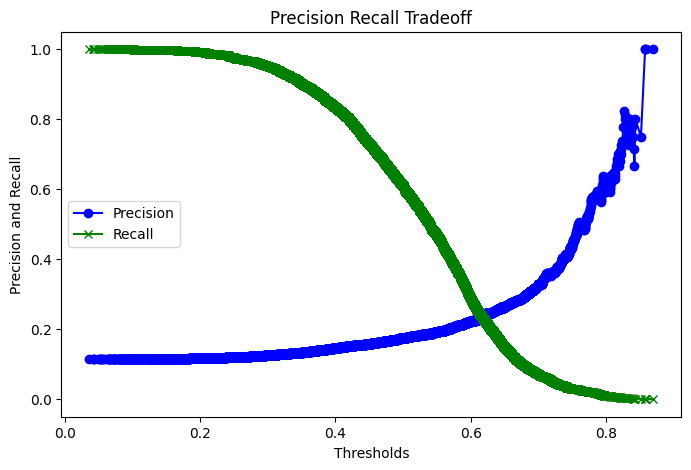

In [12]:
from sklearn.metrics import precision_recall_curve

plt.figure(figsize = (8, 5))
prec, rec, thresh = precision_recall_curve(y_test, y_test_prob)
plt.plot(thresh, prec[1:], marker = 'o', c = 'b', label = 'Precision')
plt.plot(thresh, rec[1:], marker = 'x', c = 'g', label = 'Recall')
plt.legend(loc = 'center left')
plt.xlabel("Thresholds")
plt.ylabel('Precision and Recall')
plt.title('Precision Recall Tradeoff')
plt.show()

As we increase the Recall, the precision decreases which means that if we want to reduce the number of False Negatives our False Positives will increase.

In [13]:
acc = []
f1 = []
prec = []
rec = []
thresh = list(range(0.1,0.86,0.5))
for i in thresh:
    pred = (y_test_prob >= i).astype(bool)
    f1.append(f1_score(y_test, pred))
    acc.append(accuracy_score(y_test, pred))
    prec.append(precision_score(y_test, pred))
    rec.append(recall_score(y_test, pred))
res = pd.DataFrame({"Thresholds" : thresh, "Accuracy" : acc, "F1" : f1, "Precision" : prec, "Recall" : rec})
res

Thresholds  Accuracy        F1  Precision    Recall
0         0.10  0.116926  0.205904   0.114776  0.999400
1         0.15  0.122832  0.206757   0.115326  0.997902
2         0.20  0.140174  0.209103   0.116866  0.992206
3         0.25  0.174960  0.213243   0.119697  0.976019
4         0.30  0.235225  0.221865   0.125569  0.951739
5         0.35  0.317056  0.232361   0.133351  0.902278
6         0.40  0.421036  0.248395   0.145894  0.835132
7         0.45  0.523849  0.259769   0.158028  0.729317
8         0.50  0.626661  0.272289   0.175284  0.609712
9         0.55  0.713780  0.272370   0.192142  0.467626
10        0.60  0.802891  0.251239   0.222402  0.288669
11        0.65  0.854881  0.190111   0.263549  0.148681
12        0.70  0.876790  0.118428   0.328338  0.072242
13        0.75  0.884551  0.055618   0.441964  0.029676
14        0.80  0.885821  0.018885   0.603774  0.009592
15        0.85  0.885547  0.002394   0.800000  0.001199

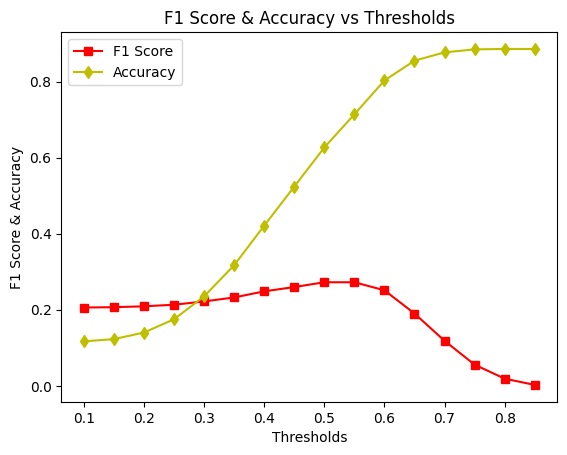

In [14]:
plt.plot(thresh, f1, marker = 's', c = 'r', label = 'F1 Score')
plt.plot(thresh, acc, marker = 'd', c = 'y', label = 'Accuracy')
plt.xlabel('Thresholds')
plt.ylabel('F1 Score & Accuracy')
plt.title('F1 Score & Accuracy vs Thresholds')
plt.legend(loc = 'best')
plt.show()

Best Threshold=0.498919, G-Mean=0.620


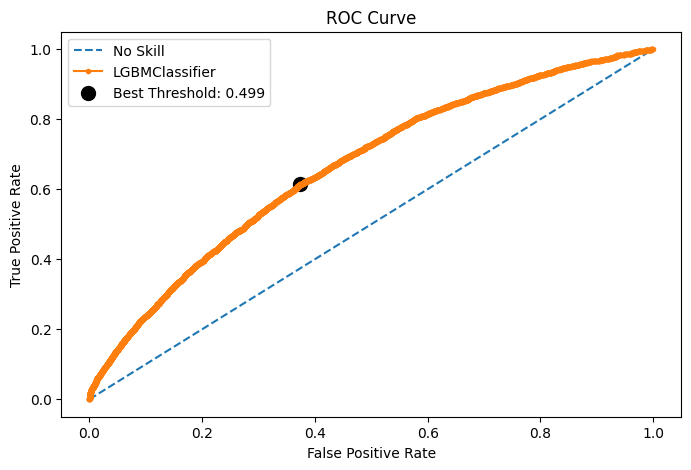

In [15]:
from sklearn.metrics import roc_curve
plt.figure(figsize = (8, 5))
# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_test, y_test_prob)
# calculate the g-mean for each threshold
gmeans = np.sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='LGBMClassifier')
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', alpha = 1, edgecolors = 'k', s = 100,
            label='Best Threshold: '+str(round(thresholds[ix], 3)))
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC Curve")
plt.legend(loc = 'best')
# show the plot
plt.show()

In [16]:
y_train_pred = (y_train_prob >= 0.487).astype(bool)
y_test_pred = (y_test_prob >= 0.487).astype(bool)
print("Train Accuracy Score:", accuracy_score(y_train, y_train_pred))
print("Train Confusion Matrix:\n", confusion_matrix(y_train, y_train_pred), '\n')
print("Train F1 Score:", f1_score(y_train, y_train_pred))
print("Train Precision Score:", precision_score(y_train, y_train_pred))
print("Train Recall Score:", recall_score(y_train, y_train_pred))
print("Train ROC_AUC Score:", roc_auc_score(y_train, y_train_prob))
print()
print("Test Accuracy Score:", accuracy_score(y_test, y_test_pred))
print("Test Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred), '\n')
print("Test F1 Score:", f1_score(y_test, y_test_pred))
print("Test Precision Score:", precision_score(y_test, y_test_pred))
print("Test Recall Score:", recall_score(y_test, y_test_pred))
print("Test ROC_AUC Score:", roc_auc_score(y_test, y_test_prob))

Train Accuracy Score: 0.6150200885958587
Train Confusion Matrix:
 [[36156 24009]
 [ 2150  5634]] 

Train F1 Score: 0.3010660752932375
Train Precision Score: 0.19006173464224269
Train Recall Score: 0.723792394655704
Train ROC_AUC Score: 0.7283908400579462

Test Accuracy Score: 0.598605817107929
Test Confusion Matrix:
 [[15296 10489]
 [ 1200  2136]] 

Test F1 Score: 0.2676524027316584
Test Precision Score: 0.1691881188118812
Test Recall Score: 0.6402877697841727
Test ROC_AUC Score: 0.6633169787613771


In [17]:
import shap
explainer = shap.TreeExplainer(model, data=X_train)
shap_values = explainer.shap_values(X_test)
pd.DataFrame(shap_values).head()

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
 99%|===================| 28851/29121 [02:01<00:01]        

0         1         2         3         4         5         6   \
0 -0.010778  0.059393  0.081211  0.040438 -0.009286 -0.026870 -0.042761   
1 -0.011666 -0.128968  0.008521  0.022449  0.058415 -0.012869 -0.076112   
2 -0.006965 -0.039489 -0.012777  0.024517  0.033415 -0.024302  0.024635   
3  0.008284  0.019044  0.063132 -0.126698 -0.151562 -0.389135  0.028837   
4  0.006694 -0.101536  0.056813  0.042633  0.011411  0.037923 -0.029964   

         7    8         9   ...   85        86        87        88        89  \
0  0.024169  0.0  0.004688  ...  0.0 -0.000151  0.012451 -0.000305 -0.000490   
1  0.027320  0.0  0.003844  ...  0.0 -0.000151  0.001546 -0.000843 -0.000183   
2  0.020226  0.0  0.011689  ...  0.0 -0.000226  0.001403  0.001954  0.000383   
3  0.030583  0.0  0.002204  ...  0.0 -0.000190  0.000836  0.000339 -0.000146   
4  0.002114  0.0 -0.000066  ...  0.0 -0.000226  0.001248  0.000643 -0.000253   

         90        91        92   93        94  
0  0.005140  0.000907 -0.022308  0.0 -0.006206  
1  0.006359  0.000690  0.072755  0.0 -0.000440  
2  0.008989  0.000451 -0.039155  0.0 -0.001055  
3 -0.001555  0.000626 -0.049073  0.0 -0.000593  
4  0.002755  0.000756 -0.012770  0.0  0.003708  

[5 rows x 95 columns]

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


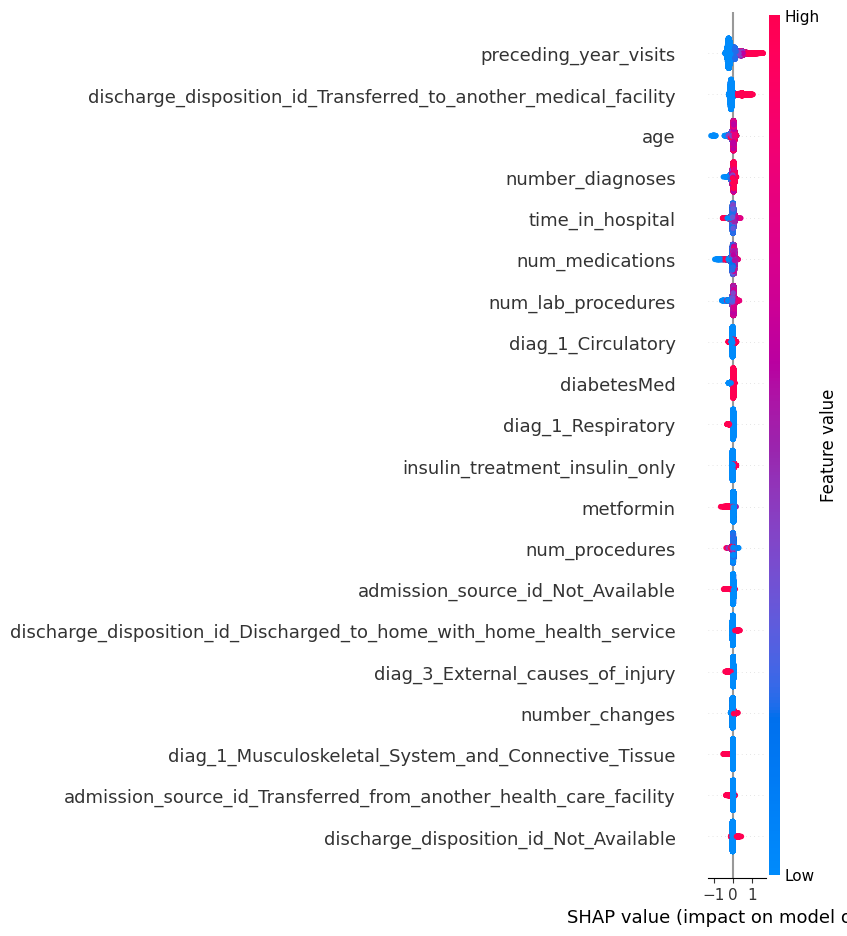

In [18]:
shap.summary_plot(shap_values, X_test)

In [19]:
from lightgbm import LGBMClassifier
from lime.lime_tabular import LimeTabularExplainer


# Generate some random data for demonstration
X = pd.DataFrame({'time_in_hospital': np.random.rand(1000), 'number_emergency': np.random.rand(1000)})
y = pd.Series(np.random.randint(0, 2, 1000))

# Encode labels using LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the LightGBM model
model = LGBMClassifier(objective='binary', random_state=0, n_jobs=-1, is_unbalance=True,
                       boosting_type='gbdt', learning_rate=0.06475, max_depth=178,
                       min_child_samples=22, n_estimators=128, num_leaves=23)
model.fit(X_train, y_train)

# Define feature names
feature_names = X_train.columns.tolist()

# Create a LimeTabularExplainer with feature_names
exp = LimeTabularExplainer(X_test.values, feature_names=feature_names, 
                           discretize_continuous=True, 
                           class_names=['Not Readmitted', 'Readmitted < 30 Days'])

# Choose an instance to explain (e.g., instance 0)
instance_idx = 0
explanation = exp.explain_instance(X_test.values[instance_idx], model.predict_proba)

# Print the explanation
explanation.show_in_notebook()


[LightGBM] [Info] Number of positive: 409, number of negative: 391
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000069 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 800, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.511250 -> initscore=0.045008
[LightGBM] [Info] Start training from score 0.045008


In [21]:
X_test = X_test.reset_index(drop = True )
# y_test = y_test.reset_index(drop = True )

In [22]:
doc_num = 1
print('Actual Label:', y_test[doc_num])
print('Predicted Label:', y_test_pred[doc_num].astype('int'))
exp.explain_instance(X_test.iloc[doc_num].values, 
                     model.predict_proba, 
                     num_samples=50000).show_in_notebook()

Actual Label: 0
Predicted Label: 0


In [23]:
doc_num = 5
print('Actual Label:', y_test[doc_num])
print('Predicted Label:', y_test_pred[doc_num].astype('int'))
exp.explain_instance(X_test.iloc[doc_num].values, 
                     model.predict_proba, 
                     num_samples=50000).show_in_notebook()

Actual Label: 1
Predicted Label: 1


In [25]:
doc_num = 20
print('Actual Label:', y_test[doc_num])
print('Predicted Label:', y_test_pred[doc_num].astype('int'))
exp.explain_instance(X_test.iloc[doc_num].values, 
                     model.predict_proba, 
                     num_samples=50000).show_in_notebook()

Actual Label: 0
Predicted Label: 0
